# Sector Sensitivity to Canadian Federal Election Polling Surprises (2015-2025)
**Author:** Rishi Paladugu  
**Date:** August 2025  
**Project:** Independent Event Study  

---
## Introduction
This project is an event study of the last decade of Canadian federal elections, analyzing sector-level abnormal returns and volatility in response to polling surprises, or the gap between final polling averages and actual results.  

To do this, we estimate:
- **Cumulative Abnormal Returns (CARs)** to measure election-driven price shifts.
- **Volatility changes** to capture post-election uncertainty.

**Objective:** Identify which sectors are most sensitive to political shocks and whether polling surprise magnitude predicts market impact.


In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

### Step 1: Define Sector, Macro, and Election Parameters

To start, we set up the key inputs for the analysis:

- **Sector ETFs**: proxies for major areas of the Canadian equity market:  
  - Energy (`XEG.TO`), Banks (`ZEB.TO`), Real Estate (`XRE.TO`), Utilities (`XUT.TO`), Tech/Industrials (`XIT.TO`).
- **Macro Indicators**: context for understanding market-wide and global conditions:  
  - TSX Composite (`^GSPTSE`, benchmark), WTI Oil (`CL=F`), USD/CAD (`CAD=X`), S&P 500 (`^GSPC`).

Additional parameters:
- **Election Dates**: the last decade of Canadian federal elections (2015, 2019, 2021, and 2025).  
  The data window spans from 180 days before to 30 days after each election for estimation and event windows.
- **Estimated Sector Market Caps**: in billions of CAD, used to convert CARs into dollar terms.
- **Polling Surprise Values**: difference between final polling average and actual result (in percentage points), used to measure the unexpectedness of each election outcome.

In [2]:
sector_names = {
    "XEG.TO": "Energy",
    "ZEB.TO": "Banks",
    "XRE.TO": "Real Estate",
    "XUT.TO": "Utilities",
    "XIT.TO": "Tech/Industrials"
}

macro_tickers = {
    "^GSPTSE": "TSX Composite",
    "CL=F": "WTI Oil",
    "CAD=X": "USD/CAD",
    "^GSPC": "S&P 500"
}

tickers = list(sector_names.keys()) + list(macro_tickers.keys())
benchmark_ticker = "^GSPTSE"
benchmark_label = macro_tickers[benchmark_ticker]

election_dates = pd.to_datetime(["2015-10-19", "2019-10-21", "2021-09-20", "2025-04-28"])
start_date = min(election_dates) - timedelta(days=180)
end_date = max(election_dates) + timedelta(days=30)

sector_caps = {
    "XEG.TO": 12.0,   
    "XRE.TO": 9.5,    
    "XIT.TO": 8.0,    
    "ZEB.TO": 15.0,   
    "XUT.TO": 6.0     
}

polling_surprise = {
    "2015-10-19": 0.7,
    "2019-10-21": 1.2,
    "2021-09-20": 1.4,
    "2025-04-28": 2.3
}

### Step 2: Download Price Data and Compute Returns

Using the Yahoo Finance API (`yfinance`), we will download daily adjusted close prices for all sector ETFs and macro indicators that are relevant to our timeframe.

**Processing steps:**
1. **Data Cleaning**  
   - Convert all price columns to numeric.  
   - Forward-fill and backfill missing values for continuity.
2. **Return Calculation**  
   - Compute daily percentage returns.  
   - Replace any infinite values with zero (common in illiquid ETF days).  
   - Drop rows where the benchmark (TSX Composite) is missing for a consistent estimation base.

This will form the basis for the **market model regression** in the event study.

In [3]:
data = yf.download(
    tickers=tickers,
    start=start_date.strftime('%Y-%m-%d'),
    end=end_date.strftime('%Y-%m-%d'),
    auto_adjust=True,
    progress=False
)

price_close = data['Close']
price_close = price_close.apply(pd.to_numeric, errors="coerce").ffill().bfill()

daily_returns = price_close.pct_change()
daily_returns = daily_returns.replace([np.inf, -np.inf], 0.0)
daily_returns = daily_returns.dropna(subset=[benchmark_ticker])

### Step 3: Estimating Cumulative Abnormal Returns (CARs)

Here we begin the market model event study, using it to measure how each sector’s returns differ from expectations during election windows.

**Parameters:**
- **Estimation Window:** 60 trading days before the event window to fit the market model.
- **Event Window:** From 1 trading day before the election to 5 trading days after.

**Method:**
1. For each election date:
   - Identify the event and estimation periods in the returns dataset.
   - Skip elections if data coverage is incomplete or if the election date isn’t a trading day.
2. For each sector ETF:
   - Run an OLS regression of sector returns on the TSX Composite returns in the estimation window.
   - Use the regression to predict expected returns in the event window.
   - Compute abnormal returns = actual – expected.
   - Sum the abnormal returns across the event window to get the Cumulative Abnormal Return (CAR).

The output is a CAR value for each sector–election pair, quantifying both the direction and magnitude of the market’s response.  

In [4]:
estimation_window = 60      
event_pre_days = 1         
event_post_days = 5   

car_results = []
all_dates = daily_returns.index
election_dates = pd.to_datetime(election_dates)
for date in election_dates:
    if date not in all_dates:
        print(f"SKIP {date.date()}: NOT A TRADING DAY")
        continue
    try:
        event_center = all_dates.get_loc(date)
        event_range = all_dates[event_center - event_pre_days : event_center + event_post_days + 1]
        est_range = all_dates[event_center - event_pre_days - estimation_window : event_center - event_pre_days]
    except IndexError:
        print(f"SKIP {date.date()}: INSUFFICIENT DATA")
        continue

    event_data = daily_returns.loc[event_range]
    est_data = daily_returns.loc[est_range]

    for col in daily_returns.columns:
        if col == benchmark_ticker:
            continue

        X = sm.add_constant(est_data[benchmark_ticker])
        y = est_data[col]
        model = sm.OLS(y, X).fit()
        X_event = sm.add_constant(event_data[benchmark_ticker])
        expected = model.predict(X_event)
        abnormal = event_data[col] - expected
        CAR = abnormal.sum()

        car_results.append({
            "ElectionDate": pd.to_datetime(date.date()),
            "Sector": col,
            "Ticker": col,
            "CAR": CAR
        })

### Step 4: Convert CARs to Dollar Terms & Link to Polling Surprises

With CARs calculated, the next step is to transform them into interpretable financial terms and connect them to political shocks:  
1. **Filter for sector ETFs**: remove macro indicators (oil, FX, S&P 500) so the focus is just on Canadian equity sectors.
2. **Attach Market Caps**: map each ETF to its estimated market capitalization (in billions of CAD).
3. **Link Polling Surprises**: join the polling miss values for each election date to quantify the *unexpectedness* of results
4. **Convert to Dollar Impact**  
   - `CAR_dollar_M` = CAR × market cap (in millions CAD)  
   - `CAR_percent_of_cap` = CAR as a percentage of sector market capitalization

This produces CARs in comparable, dollar-based terms directly linked to the magnitude of polling shocks.  

In [5]:
car_df = pd.DataFrame(car_results)
car_df = car_df[car_df["Ticker"].isin(sector_caps)].copy()
car_df["MarketCap_B"] = car_df["Ticker"].map(sector_caps)
car_df["PollingSurprise"] = car_df["ElectionDate"].dt.strftime("%Y-%m-%d").map(polling_surprise)
car_df["CAR_dollar_M"] = (car_df["CAR"] * car_df["MarketCap_B"] * 1000).round(2)
car_df["CAR_percent_of_cap"] = 100 * car_df["CAR"]

### Step 5: Volatility Analysis: Measuring Market Uncertainty Shifts

Beyond price direction (CARs), we also measure changes in return volatility to capture how investor uncertainty changes after an election.

**Method:**
1. For each sector and election:
   - **Pre-election window:** 60 trading days before election day  
   - **Post-election window:** 60 trading days after election day
2. Compute the standard deviation of daily returns in both periods.
3. Calculate the volatility jump: 
Volatility Jump (%) = $\frac{\sigma_{\text{post}} - \sigma_{\text{pre}}}{\sigma_{\text{pre}}} \times 100$
4. Store results in a separate DataFrame (`vol_df`) for merging with the CAR dataset.

This metric helps identify sectors where uncertainty (not just returns) reacts strongly to unexpected political outcomes.

In [6]:
vol_data = []
for _, row in car_df.iterrows():
    date = row["ElectionDate"]
    ticker = row["Ticker"]
    try:
        pre = daily_returns.loc[date - timedelta(days=60): date - timedelta(days=1), ticker]
        post = daily_returns.loc[date + timedelta(days=1): date + timedelta(days=60), ticker]
        std_pre = pre.std()
        std_post = post.std()
        vol_jump = 100 * (std_post - std_pre) / std_pre if std_pre > 0 else np.nan
    except:
        std_pre, std_post, vol_jump = np.nan, np.nan, np.nan

    vol_data.append({
        "ElectionDate": date,
        "Ticker": ticker,
        "StdDev_Pre": std_pre,
        "StdDev_Post": std_post,
        "Volatility_Jump_Percent": vol_jump
    })

vol_df = pd.DataFrame(vol_data)


### Step 6: Merge Results & Create Summary Tables

We combine the CAR dataset with the volatility dataset to produce a **final summary table** which we will use for analysis and visualization.

**Steps:**
1. **Merge** `car_df` (CAR results) and `vol_df` (volatility results) on `ElectionDate` and `Ticker`.
2. **Select Final Columns**:
   - Election date, sector ticker, CAR values (raw, % of market cap, dollar terms), polling surprise, pre/post volatility, volatility jump.
3. **Save Outputs**:
   - `election_impact_summary.csv`: full results by sector and election.
   - `sector_summary_table.csv`: aggregated results by sector, showing:
     - Average and standard deviation of CARs (% of market cap)
     - Average and maximum volatility jumps (%)
4. **Map Sector Names**: replace tickers with human-readable sector labels for clarity in visualizations.

With this, now we are able to construct visuals and interpret our findings.

In [7]:
final = car_df.merge(vol_df, on=["ElectionDate", "Ticker"])
final = final[[
    "ElectionDate", "Ticker", "CAR", "MarketCap_B", "CAR_dollar_M",
    "CAR_percent_of_cap", "PollingSurprise", "StdDev_Pre", "StdDev_Post", "Volatility_Jump_Percent"
]]

final.to_csv("election_impact_summary.csv", index=False)
final["Sector"] = final["Ticker"].map(sector_names)
final["ElectionDate"] = pd.to_datetime(final["ElectionDate"]).dt.strftime("%Y-%m-%d")

summary = final.groupby("Ticker").agg({
    "CAR_percent_of_cap": ["mean", "std"],
    "Volatility_Jump_Percent": ["mean", "max"]
}).round(2)
print(summary)
summary.to_csv("sector_summary_table.csv")

       CAR_percent_of_cap       Volatility_Jump_Percent        
                     mean   std                    mean     max
Ticker                                                         
XEG.TO               0.08  7.49                  -26.51  -10.45
XIT.TO              -0.71  2.04                   11.04  117.16
XRE.TO              -0.55  1.85                   -3.49   25.55
XUT.TO              -0.92  1.27                   -8.67   30.38
ZEB.TO               2.00  1.47                  -33.16    9.37


**Table Interpretation: Sector Summary**  

This table aggregates results **across all elections** for each sector ETF:  

- **CAR_percent_of_cap (mean, std):**  
  - The average and variability of abnormal returns as a percentage of sector market cap.  
- **Volatility_Jump_Percent (mean, max):**  
  - The average and peak percentage change in volatility following elections.  

**Observations:**  
- **Banks (ZEB.TO)** show the highest average CARs (+2% of market cap) but also the largest average volatility drop (–33%), suggesting strong positive revaluations paired with reduced uncertainty post-election.  
- **Tech/Industrials (XIT.TO)** have modest negative average CARs (–0.71%) but experienced the largest volatility spike on record (+117%).  
- **Energy (XEG.TO)** shows slightly positive average CARs (+0.08%) with moderate average volatility declines, indicating relative stability compared to other sectors.  

This summary provides a high-level view of sector sensitivity and highlights candidates for deeper, event-specific investigation.  

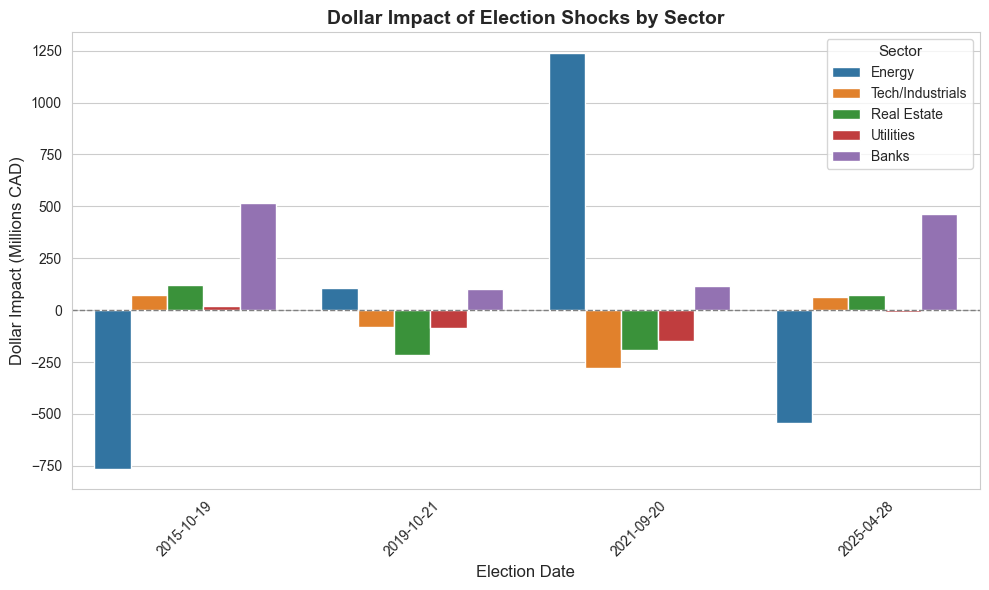

In [ ]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.barplot(data=final, x="ElectionDate", y="CAR_dollar_M", hue="Sector")

plt.title("Dollar Impact of Election Shocks by Sector", fontsize=14, weight='bold')
plt.ylabel("Dollar Impact (Millions CAD)", fontsize=12)
plt.xlabel("Election Date", fontsize=12)
plt.xticks(rotation=45)
plt.axhline(0, linestyle="--", color="gray", linewidth=1)
plt.legend(title="Sector", title_fontsize=11, fontsize=10)
plt.tight_layout()
plt.savefig("bar_dollar_impact_by_sector.png", dpi=300)
plt.show()


**Figure: Dollar Impact of Election Shocks by Sector**  

This bar chart shows cumulative abnormal returns (CARs) converted into millions of CAD for each sector ETF across the four Canadian federal elections in the sample.  

**Interpretation:**  
- The 2021 election saw an exceptionally large positive dollar impact for Energy, far exceeding impacts in other sectors and years.  
- Banks experienced significant gains in 2015 and 2025, suggesting favorable market expectations from anticipated policy or regulatory changes.  
- Energy showed substantial negative impacts in 2015 and 2025, implying high sensitivity to electoral outcomes.  
- Losses in Tech/Industrials in 2019 and 2021 occurred despite varied political contexts, indicating possible exposure to broader market or industry-specific factors beyond politics.  

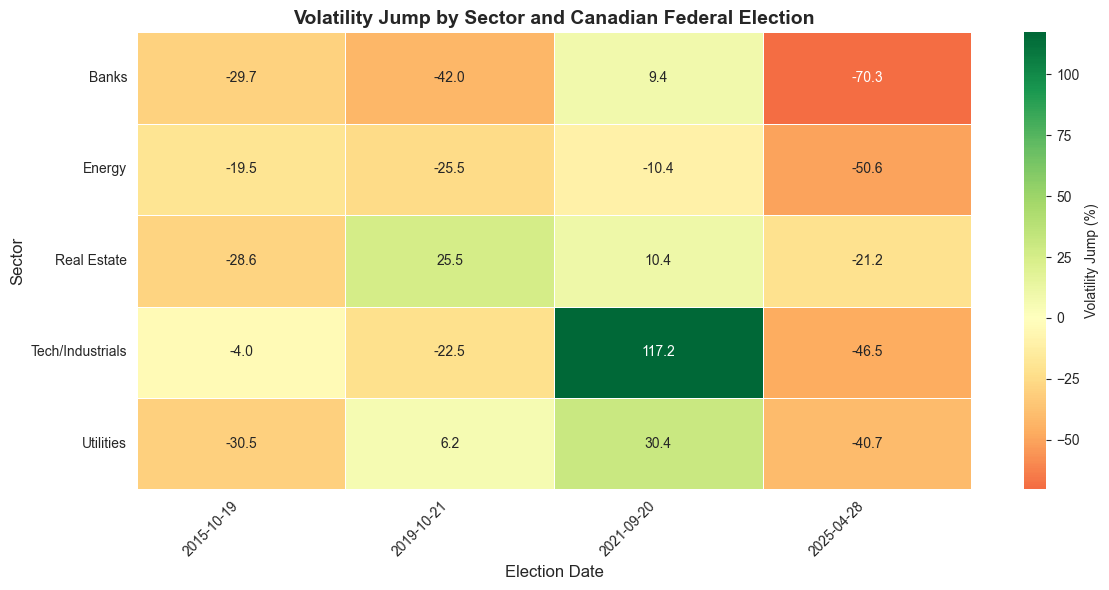

In [9]:
heatmap_data = final.pivot(index="Sector", columns="ElectionDate", values="Volatility_Jump_Percent")

plt.figure(figsize=(12, 6))

ax = sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1f",
    cmap="RdYlGn",
    center=0,
    linewidths=0.5,
    cbar_kws={"label": "Volatility Jump (%)"}
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.title("Volatility Jump by Sector and Canadian Federal Election", fontsize=14, weight="bold")
plt.xlabel("Election Date", fontsize=12)
plt.ylabel("Sector", fontsize=12)
plt.tight_layout()
plt.savefig("heatmap_volatility_jump.png", dpi=300)
plt.show()


**Figure: Volatility Jump by Sector and Canadian Federal Election**  

This heatmap shows the percentage change in volatility for each sector ETF in the days immediately following each federal election in the sample. Positive values indicate a post-election increase in volatility, while negative values indicate a decline.  

**Interpretation:**  
- **Tech/Industrials (XIT.TO)**: saw an extraordinary volatility surge in 2021 (+117%), far exceeding any other sector-year combination.  
- **Banks (ZEB.TO)**: consistently experienced large volatility declines post-election, most notably in 2025 (–70%).  
- **Energy (XEG.TO)**/**Utilities (XUT.TO)**: tended toward volatility drops in most elections, though Utilities posted a notable +30% spike in 2021.  
- **Real Estate (XRE.TO)**: exhibited mixed behavior, with both large increases (2019) and sizable decreases (2015, 2025).  

This visualization highlights the differing volatility responses of sectors to electoral outcomes, which can signal how political events alter uncertainty in sector-specific markets.  

## Conclusion  

This case study shows that Canadian equity sectors respond unevenly to federal election outcomes: Banks often experience positive revaluations with reduced uncertainty, Tech/Industrials display the largest volatility spikes, and Energy emerges as the most politically sensitive sector, with both strong gains and steep losses depending on context. That said, correlations are not particularly strong and results remain uneven, underscoring the need to interpret conclusions with caution.  

Overall, the findings suggest that:  
- **Policy-sensitive sectors** (Energy and Banks) react strongly to electoral outcomes.  
- **Volatility responses** vary sharply by sector, reflecting differences in investor uncertainty.  
- **Polling surprises** help explain the magnitude of market shifts, linking political expectations to financial reactions.  

While limited to four elections, this analysis shows both how an event study framework can connect politics and finance, but also how nuanced and complex that connection is. More election-specific studies would be valuable for deepening our understanding of this intersection.  

## References

**Election Polling Data**
- Wikipedia contributors. (n.d.). *Opinion polling for the 2015 Canadian federal election*. Wikipedia. Retrieved July 2025, from https://en.wikipedia.org/wiki/Opinion_polling_for_the_2015_Canadian_federal_election  
- Wikipedia contributors. (n.d.). *Opinion polling for the 2019 Canadian federal election*. Wikipedia. Retrieved July 2025, from https://en.wikipedia.org/wiki/Opinion_polling_for_the_2019_Canadian_federal_election  
- Wikipedia contributors. (n.d.). *Opinion polling for the 2021 Canadian federal election*. Wikipedia. Retrieved July 2025, from https://en.wikipedia.org/wiki/Opinion_polling_for_the_2021_Canadian_federal_election  
- Wikipedia contributors. (n.d.). *Opinion polling for the 2025 Canadian federal election*. Wikipedia. Retrieved July 2025, from https://en.wikipedia.org/wiki/Opinion_polling_for_the_2025_Canadian_federal_election  

**ETF Market Capitalization & Profile Data**
- BlackRock Canada. (n.d.). *iShares S&P/TSX Capped Information Technology Index ETF (XIT.TO)*. Retrieved July 2025, from https://www.blackrock.com/ca/investors/en/products/239841/ishares-sptsx-capped-information-technology-index-etf  
- BlackRock Canada. (n.d.). *iShares S&P/TSX Capped Energy Index ETF (XEG.TO)*. Retrieved July 2025, from https://www.blackrock.com/ca/investors/en/products/239839/ishares-sptsx-capped-energy-index-etf  
- Yahoo Finance. (n.d.). *ZEB.TO – BMO Equal Weight Banks Index ETF*. Retrieved July 2025, from https://finance.yahoo.com/quote/ZEB.TO  
- Yahoo Finance. (n.d.). *XRE.TO – iShares S&P/TSX Capped REIT Index ETF*. Retrieved July 2025, from https://finance.yahoo.com/quote/XRE.TO  
- Yahoo Finance. (n.d.). *XUT.TO – iShares S&P/TSX Capped Utilities Index ETF*. Retrieved July 2025, from https://finance.yahoo.com/quote/XUT.TO  
